# Recomendador de inversiones inmoviliarias

## Datos origen:

- [Precio_medio_EUR_m2_alquiler](datasets/Precio_medio_EUR_m2_alquiler.csv)
- [Precio_medio_EUR_m2_compraventa](datasets/Precio_medio_EUR_m2_compraventa.csv)
- [BarcelonaCiutat_SeccionsCensals](datasets/BarcelonaCiutat_SeccionsCensals.csv)


## Tareas:

1. Dentificar toda la jerarquia de distritos y barrios
1. Modelo de ML para extrapolar precios estadístico de alquiler y compraventa a fecha de hoy
1. Asignar precio estadístico de alquiler y compraventa a cada inmueble basado en su barrio o distrito
1. Crear una puntuación para cada barrio o distrito de 0 a 1
1. Crear una puntuación para el precio de compra para cada inmueble de 0 a 1 en función del precio estadístico de compra de cada barrio o distrito
1. Crear una puntuación para el precio de alquiler para cada inmueble de 0 a 1 en función del precio estadístico de alquiler de cada barrio o distrito
1. Calcular la tasa de retorno de cada inmueble en función del precio de compra y el precio de alquiler
1. Crear una puntuación final para cada inmueble de 0 a 1 en función de las puntuaciones anteriores


In [32]:
!pip install openpyxl scikit-learn

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


## Carga de datos de Barcelona Datos con el Precio medio por superficie (€/m²) del alquiler de viviendas por distrito

Renta media mensual por superficie (€/m²) de alquiler de viviendas procedente de la estadística de fianzas del INCASOL. Se puede considerar que esta estadística tiene un carácter censal ya que se basa en el recuento de todos los contratos de alquiler que han depositado la fianza en el Incasòl en el período considerado.

La información de distritos y barrios está elaborada a partir de aquéllos viviendas que se han podido geolocalizar. El total de Barcelona puede no coincidir con la suma de compraventas de los distritos o de los barrios.No se publica la información de los ámbitos de menos de seis contratos registrados.

In [34]:
# Carga de datos de Barcelona Datos con el Precio medio por superficie (€/m²) del alquiler de viviendas por distrito

bcn_alquiler = pd.read_csv('datasets/Precio_medio_EUR_m2_alquiler.csv')
bcn_venta = pd.read_csv('datasets/Precio_medio_EUR_m2_compraventa.csv')
bcn_superficie_venta = pd.read_csv('datasets/Superficie_m2_tipo_compraventa.csv')

# Renombrado de columnas
bcn_alquiler.columns = ['mes', 'nombre', 'orden', 'tipo', 'precio_alquiler']
bcn_venta.columns = ['mes', 'nombre', 'orden', 'tipo', 'precio_venta']
bcn_superficie_venta.columns = ['mes', 'nombre', 'orden', 'tipo', 'uso', 'superficie_venta']

# Conversión de mes a periodo
bcn_alquiler['mes'] = pd.to_datetime(bcn_alquiler['mes'])#.dt.to_period('M')
bcn_venta['mes'] = pd.to_datetime(bcn_venta['mes'])#.dt.to_period('M')
bcn_superficie_venta['mes'] = pd.to_datetime(bcn_venta['mes'])#.dt.to_period('M')

# limpieza de datos anteriores a 2014
bcn_alquiler = bcn_alquiler[bcn_alquiler['mes'].dt.year >= 2014]
bcn_venta = bcn_venta[bcn_venta['mes'].dt.year >= 2014]
bcn_superficie_venta = bcn_superficie_venta[(bcn_superficie_venta['mes'].dt.year >= 2014) & (bcn_superficie_venta['uso'] == 'Residencial')]

# Eliminación de columnas sobrantes
bcn_alquiler.drop('orden', axis=1, inplace=True)
bcn_venta.drop('orden', axis=1, inplace=True)
bcn_superficie_venta.drop(['orden','uso'], axis=1, inplace=True)

# Calculo de duplicado de fechas a la media de precio
bcn_alquiler = bcn_alquiler.groupby(by=['tipo','nombre','mes'])['precio_alquiler'].mean().reset_index()
bcn_venta = bcn_venta.groupby(by=['tipo','nombre','mes'])['precio_venta'].mean().reset_index()
bcn_superficie_venta = bcn_superficie_venta.groupby(by=['tipo','nombre','mes'])['superficie_venta'].sum().reset_index()

# Unión de las dos tablas
bcn_precios = pd.merge(bcn_alquiler, bcn_venta, on=['tipo','nombre','mes'], how='outer')
bcn_precios = pd.merge(bcn_precios, bcn_superficie_venta, on=['tipo','nombre','mes'], how='outer')
bcn_precios

tipo         nombre                       mes  precio_alquiler  \
0        Barri  Baró de Viver 2014-01-01 00:00:00+00:00         3.920000   
1        Barri  Baró de Viver 2014-03-01 00:00:00+00:00              NaN   
2        Barri  Baró de Viver 2014-04-01 00:00:00+00:00         4.030000   
3        Barri  Baró de Viver 2014-11-01 00:00:00+00:00              NaN   
4        Barri  Baró de Viver 2015-01-01 00:00:00+00:00         4.929844   
...        ...            ...                       ...              ...   
9502  Municipi      Barcelona 2024-05-01 00:00:00+00:00              NaN   
9503  Municipi      Barcelona 2024-06-01 00:00:00+00:00              NaN   
9504  Municipi      Barcelona 2024-07-01 00:00:00+00:00              NaN   
9505  Municipi      Barcelona 2024-08-01 00:00:00+00:00              NaN   
9506  Municipi      Barcelona 2024-09-01 00:00:00+00:00              NaN   

      precio_venta  superficie_venta  
0       438.500000              92.0  
1              NaN              56.0  
2              NaN               NaN  
3              NaN             154.0  
4       634.307692               NaN  
...            ...               ...  
9502   3792.943830               NaN  
9503   3845.827810          122345.0  
9504   3835.180837               NaN  
9505   3832.821747               NaN  
9506   3920.930902               NaN  

[9507 rows x 6 columns]

In [35]:
#crear los registros que faltan de mes con precio_alquiler y precio_venta nulos
print('Antes:',bcn_precios[bcn_precios['nombre'] == 'baro de viver'].shape[0])

# Generar un df con todas las fechas
dates = pd.DataFrame(pd.date_range(start=bcn_precios['mes'].min(), end=bcn_precios['mes'].max(), freq='MS'), columns=['mes'])
# Generar un df con los indices
elems = bcn_precios.groupby(['tipo', 'nombre']).count().reset_index()[['tipo', 'nombre']]
# Multiplicar fechas por cada indice
estrutura = pd.merge(elems, dates, how='cross')
# Unir las tablas con los valores existentes
bcn_precios = pd.merge(estrutura, bcn_precios, how='left', on=['tipo', 'nombre','mes'])

print('Despues:',bcn_precios[bcn_precios['nombre'] == 'baro de viver'].shape[0])

bcn_precios


Antes: 0
Despues: 0


tipo         nombre                       mes  precio_alquiler  \
0         Barri  Baró de Viver 2014-01-01 00:00:00+00:00             3.92   
1         Barri  Baró de Viver 2014-02-01 00:00:00+00:00              NaN   
2         Barri  Baró de Viver 2014-03-01 00:00:00+00:00              NaN   
3         Barri  Baró de Viver 2014-04-01 00:00:00+00:00             4.03   
4         Barri  Baró de Viver 2014-05-01 00:00:00+00:00              NaN   
...         ...            ...                       ...              ...   
10960  Municipi      Barcelona 2024-05-01 00:00:00+00:00              NaN   
10961  Municipi      Barcelona 2024-06-01 00:00:00+00:00              NaN   
10962  Municipi      Barcelona 2024-07-01 00:00:00+00:00              NaN   
10963  Municipi      Barcelona 2024-08-01 00:00:00+00:00              NaN   
10964  Municipi      Barcelona 2024-09-01 00:00:00+00:00              NaN   

       precio_venta  superficie_venta  
0        438.500000              92.0  
1               NaN               NaN  
2               NaN              56.0  
3               NaN               NaN  
4               NaN               NaN  
...             ...               ...  
10960   3792.943830               NaN  
10961   3845.827810          122345.0  
10962   3835.180837               NaN  
10963   3832.821747               NaN  
10964   3920.930902               NaN  

[10965 rows x 6 columns]

In [36]:
# Estandarizar nombres de distriros para facilitar la convinación de campos

import unicodedata
import html

def estandarizar(x):
    """ Estandariza el nombre de un barrio o distrito:
         - Quita entidades HTML y UTF-8
         - Normaliza el texto a forma NFD (descompone caracteres con diacríticos)
         - Filtra caracteres con categoría de diacrítico (Mn)
         - Pasa a minúsculas
         - Reemplaza guiones por espacios
         - Quita espacios dobles
    """
    # Unescape HTML and UTF-8 entities
    x = html.unescape(x)
    # Normalizar el texto a forma NFD (descompone caracteres con diacríticos)
    x = unicodedata.normalize('NFD', x)
    # Filtrar caracteres con categoría de diacrítico (Mn)
    x = ''.join(c for c in x if unicodedata.category(c) != 'Mn')
    return x.split(' - AEI ')[0].replace('-', ' ').replace('  ', ' ').lower()

# Cargar estructura de jerarquica de municipio - distrito - barrio
barrios = pd.read_csv('datasets/BarcelonaCiutat_SeccionsCensals.csv')
barrios = barrios.groupby('nom_barri').min().drop(['codi_seccio_censal','geometria_etrs89','geometria_wgs84','codi_aeb'], axis=1).sort_values(by='codi_barri').reset_index()

bcn_precios[['nombre', 'tipo']] = bcn_precios[['nombre', 'tipo']].applymap(estandarizar)
barrios[['nom_barri', 'nom_districte']] = barrios[['nom_barri', 'nom_districte']].applymap(estandarizar)

# Unir a la tabla de precios la jerarquia de distritos
bcn_precios = pd.merge( bcn_precios, barrios,  left_on='nombre', right_on='nom_barri', how='left').drop('nom_barri', axis=1)

print('bcn_precios no encontrados',bcn_precios[(bcn_precios['tipo'] == 'barri') & bcn_precios['nom_districte'].isna()]['nombre'].count())

bcn_precios = bcn_precios.sort_values(by=['tipo', 'nombre', 'mes'], ascending=[True, True, True])
bcn_precios

bcn_precios no encontrados 0


tipo         nombre                       mes  precio_alquiler  \
0         barri  baro de viver 2014-01-01 00:00:00+00:00             3.92   
1         barri  baro de viver 2014-02-01 00:00:00+00:00              NaN   
2         barri  baro de viver 2014-03-01 00:00:00+00:00              NaN   
3         barri  baro de viver 2014-04-01 00:00:00+00:00             4.03   
4         barri  baro de viver 2014-05-01 00:00:00+00:00              NaN   
...         ...            ...                       ...              ...   
10960  municipi      barcelona 2024-05-01 00:00:00+00:00              NaN   
10961  municipi      barcelona 2024-06-01 00:00:00+00:00              NaN   
10962  municipi      barcelona 2024-07-01 00:00:00+00:00              NaN   
10963  municipi      barcelona 2024-08-01 00:00:00+00:00              NaN   
10964  municipi      barcelona 2024-09-01 00:00:00+00:00              NaN   

       precio_venta  superficie_venta  codi_districte nom_districte  \
0        438.500000              92.0             9.0   sant andreu   
1               NaN               NaN             9.0   sant andreu   
2               NaN              56.0             9.0   sant andreu   
3               NaN               NaN             9.0   sant andreu   
4               NaN               NaN             9.0   sant andreu   
...             ...               ...             ...           ...   
10960   3792.943830               NaN             NaN           NaN   
10961   3845.827810          122345.0             NaN           NaN   
10962   3835.180837               NaN             NaN           NaN   
10963   3832.821747               NaN             NaN           NaN   
10964   3920.930902               NaN             NaN           NaN   

       codi_barri  
0            58.0  
1            58.0  
2            58.0  
3            58.0  
4            58.0  
...           ...  
10960         NaN  
10961         NaN  
10962         NaN  
10963         NaN  
10964         NaN  

[10965 rows x 9 columns]

In [37]:
def fill_district(df):

    # Filtrar registros de tipo "Districte"
    df_districte = df[df['tipo'] == 'districte']

    # Actualizar columnas `codi_districte` y `nom_districte`
    for index, row in df_districte.iterrows():
        match = barrios[barrios['nom_districte'] == row['nombre']]
        if not match.empty:
            df.at[index, 'codi_districte'] = match.iloc[0]['codi_districte']
            df.at[index, 'nom_districte'] = match.iloc[0]['nom_districte']

fill_district(bcn_precios)

bcn_precios[['codi_districte', 'codi_barri']] = bcn_precios[['codi_districte', 'codi_barri']].fillna(-1).astype(int)
bcn_precios


tipo         nombre                       mes  precio_alquiler  \
0         barri  baro de viver 2014-01-01 00:00:00+00:00             3.92   
1         barri  baro de viver 2014-02-01 00:00:00+00:00              NaN   
2         barri  baro de viver 2014-03-01 00:00:00+00:00              NaN   
3         barri  baro de viver 2014-04-01 00:00:00+00:00             4.03   
4         barri  baro de viver 2014-05-01 00:00:00+00:00              NaN   
...         ...            ...                       ...              ...   
10960  municipi      barcelona 2024-05-01 00:00:00+00:00              NaN   
10961  municipi      barcelona 2024-06-01 00:00:00+00:00              NaN   
10962  municipi      barcelona 2024-07-01 00:00:00+00:00              NaN   
10963  municipi      barcelona 2024-08-01 00:00:00+00:00              NaN   
10964  municipi      barcelona 2024-09-01 00:00:00+00:00              NaN   

       precio_venta  superficie_venta  codi_districte nom_districte  \
0        438.500000              92.0               9   sant andreu   
1               NaN               NaN               9   sant andreu   
2               NaN              56.0               9   sant andreu   
3               NaN               NaN               9   sant andreu   
4               NaN               NaN               9   sant andreu   
...             ...               ...             ...           ...   
10960   3792.943830               NaN              -1           NaN   
10961   3845.827810          122345.0              -1           NaN   
10962   3835.180837               NaN              -1           NaN   
10963   3832.821747               NaN              -1           NaN   
10964   3920.930902               NaN              -1           NaN   

       codi_barri  
0              58  
1              58  
2              58  
3              58  
4              58  
...           ...  
10960          -1  
10961          -1  
10962          -1  
10963          -1  
10964          -1  

[10965 rows x 9 columns]

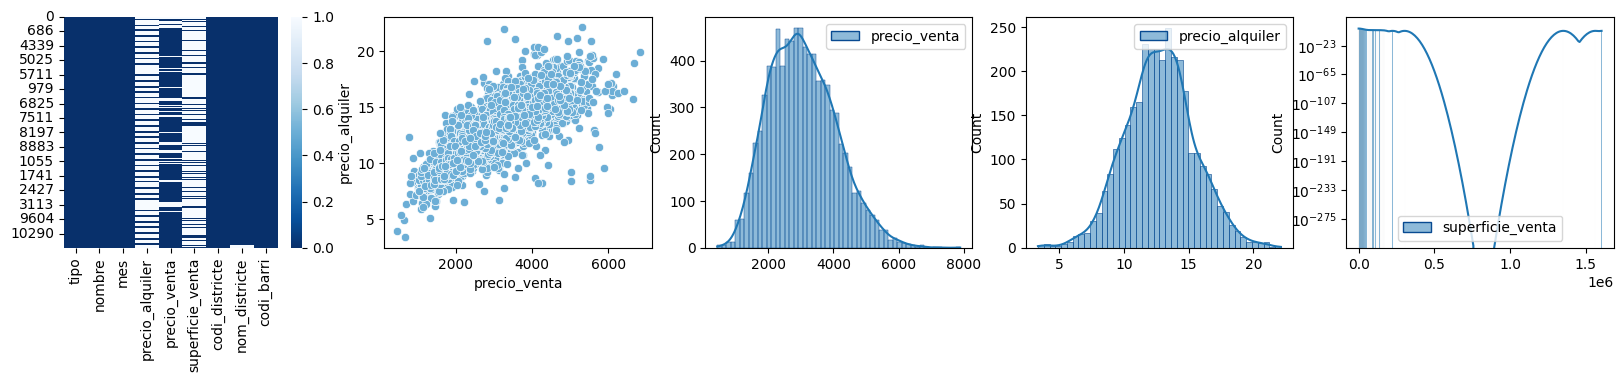

In [38]:
import matplotlib.cm as cm

def plot_data_dist(dfs):

    cmaps = ['Blues_r', 'Greens_r', 'Oranges_r', 'Reds_r', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'PuBuGn', 'PuRd', 'OrRd', 'YlGnBu', 'YlGn', 'YlOrBr', 'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'Greys', 'Purples', 'YlOrRd']

    fig, axs = plt.subplots(len(dfs), 5, figsize=(20, 3*len(dfs)))
    # plt.grid(True)
    # Crear subplots
    for idx, df in enumerate(dfs):
        sns.heatmap(df.isnull(), annot=False, cmap=cmaps[idx], ax=axs[idx, 0] if len(dfs) > 1 else axs[0])
        sns.scatterplot(df, x='precio_venta', y='precio_alquiler', color=cm.get_cmap(cmaps[idx])(0.5), ax=axs[idx, 1] if len(dfs) > 1 else axs[1])
        sns.histplot(df[['precio_venta']], kde=True, color=cm.get_cmap(cmaps[idx])(0.5), edgecolor=cm.get_cmap(cmaps[idx])(0.1), ax=axs[idx, 2] if len(dfs) > 1 else axs[2])
        sns.histplot(df[['precio_alquiler']], kde=True, color=cm.get_cmap(cmaps[idx])(0.5), edgecolor=cm.get_cmap(cmaps[idx])(0.1), ax=axs[idx, 3] if len(dfs) > 1 else axs[3])
        plt.yscale('log')
        sns.histplot(df[['superficie_venta']], kde=True, color=cm.get_cmap(cmaps[idx])(0.5), edgecolor=cm.get_cmap(cmaps[idx])(0.1), ax=axs[idx, 4] if len(dfs) > 1 else axs[4])
    plt.show()

plot_data_dist([bcn_precios])

In [39]:

# import numpy as np
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import LeaveOneOut

# def loocv_polynomial(X, y, max_degree=5):
#     """
#     Realiza Leave-One-Out Cross-Validation (LOOCV) para encontrar el mejor grado de un modelo de regresión polinómica.
    
#     Parameters:
#         X (np.ndarray): Variable independiente, array de forma (n_samples, 1).
#         y (np.ndarray): Variable dependiente, array de forma (n_samples,).
#         max_degree (int): Grado máximo del polinomio a evaluar.
    
#     Returns:
#         dict: Resultados del mejor modelo, incluyendo:
#               - 'best_degree': Mejor grado polinómico.
#               - 'lowest_mse': MSE promedio más bajo.
#               - 'model': Modelo ajustado para el mejor grado.
#               - 'mse_by_degree': Lista de MSE promedio para cada grado.
#     """
#     loo = LeaveOneOut()
#     best_degree = None
#     lowest_mse = np.inf
#     mse_by_degree = []
#     best_model = None

#     for degree in range(1, max_degree + 1):
#         mse_list = []
#         poly = PolynomialFeatures(degree)
#         X_poly = poly.fit_transform(X)
        
#         for train_index, test_index in loo.split(X_poly):
#             X_train, X_test = X_poly[train_index], X_poly[test_index]
#             y_train, y_test = y[train_index], y[test_index]
            
#             # Entrenar el modelo
#             model = LinearRegression()
#             model.fit(X_train, y_train)
            
#             # Predicción y cálculo de error
#             y_pred = model.predict(X_test)
#             mse = mean_squared_error(y_test, y_pred)
#             mse_list.append(mse)
        
#         # Calcular el MSE promedio para este grado
#         average_mse = np.mean(mse_list)
#         mse_by_degree.append((degree, average_mse))

#         if average_mse < lowest_mse:
#             best_degree = degree
#             lowest_mse = average_mse
#             best_model = model
    
#     # return lowest_mse, best_degree, best_model, best_y_full_pred
#     return {
#         'best_degree': best_degree,
#         'lowest_mse': lowest_mse,
#         'model': best_model,
#         'mse_by_degree': mse_by_degree
#     }


# # Datos de ejemplo
# X = np.array([[1], [2], [3], [4], [5]])
# y = np.array([1.2, 1.9, 3.0, 4.1, 5.1])

# # Ejecutar LOOCV para regresión polinómica
# results = loocv_polynomial(X, y, max_degree=5)

# print(f"Mejor grado polinómico: {results['best_degree']}")
# print(f"MSE promedio más bajo: {results['lowest_mse']:.4f}")
# print("MSE por grado:")
# for degree, mse in results['mse_by_degree']:
#     print(f"  Grado {degree}: MSE = {mse:.4f}")


In [40]:
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def get_best_model(X, y, mask_missing, max_degree=10):
    
    # calcular el rango entre los valores existentes
    range_value = abs(max(y) - min(y))

    best_r2 = -np.inf
    best_degree = None
    best_model = None
    best_y_full_pred = None

    # Probar diferentes grados polinómicos
    for degree in range(1, max_degree + 1):
        poly = PolynomialFeatures(degree)
        X_poly = poly.fit_transform(X[~mask_missing]) 
        y_train = y[~mask_missing]

        # Ajustar modelo
        model = LinearRegression()
        model.fit(X_poly, y_train)

        # Evaluar \( R^2 \)
        y_pred = model.predict(X_poly)
        r2 = r2_score(y_train, y_pred)

        if r2 > best_r2:
            # Comprobar que el rango de los datos predichos no supera el rango máximo permitido
            X_poly_full = poly.fit_transform(X)  # Transformar todos los datos
            y_full_pred = model.predict(X_poly_full)
            max_pred = max(y_full_pred)
            min_pred = min(y_full_pred)
            range_pred = abs(max_pred - min_pred)
            if range_pred < 1.5*range_value:
                # Los datos predichos están dentro del umbral, el modelo es aceptable
                best_r2 = r2
                best_degree = degree
                best_model = model
                best_y_full_pred = y_full_pred 

    return best_r2, best_degree, best_model, best_y_full_pred


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def fill_missing_values(data, target_column, extrapolate=False, max_degree=5):
    """
    Rellena los valores nulos de un dataset basandose en un modelo de regresión polinómica

    Parameters:
        data (pd.DataFrame): El dataset con las columnas necesarias.
        target_column (str): La columna a predecir.
        extrapolate (bool): Si debe rellenar datos más allá del periodo muestreado
        max_degree (int): Grado máximo de los polinomios a probar.

    Returns:
        dict: Diccionario con el mejor grado y \( R^2 \) por cada grupo.
        pd.DataFrame: Dataset con valores imputados para la columna objetivo.
    """
    results = {}
    data_imputed = data.copy()

    for name, group in data.groupby(['tipo','nombre']):
        group = group.sort_values('mes')  # Asegurar orden temporal

        # si no debe extrapolar, filtrar las fechas mayores que la maxima
        if not extrapolate:
            max_date = group.dropna(subset=[target_column])['mes'].max()
            group = group[group['mes'] <= max_date]

        X = np.arange(len(group)).reshape(-1, 1)  # Índices como variable independiente
        y = group[target_column].values

        # Identificar valores faltantes
        mask_missing = group[target_column].isna()
        if mask_missing.sum() == 0:
            continue  # Si no hay valores faltantes, pasar al siguiente grupo

        best_r2, best_degree, best_model, best_y_full_pred = get_best_model(X, y, mask_missing, max_degree)

        # Imputar valores faltantes con el mejor modelo
        if best_model:
            # Asignar valores imputados para los datos faltantes
            data_imputed.loc[mask_missing.index[mask_missing], target_column] = best_y_full_pred[mask_missing.to_numpy()]

        data_length =  group[target_column].dropna().shape[0]
        # Guardar resultados del mejor modelo para este grupo
        results[name] = {'name': name
            ,'best_degree': best_degree
            ,'best_r2': best_r2
            ,'real_count':data_length
            # ,'pred_count':update_count
            # ,'model':model
        }

    return results, data_imputed



results, bcn_precios_int = fill_missing_values(bcn_precios, target_column='precio_alquiler',extrapolate=False, max_degree=10)
results = pd.DataFrame.from_dict(results, orient='index').round(2).reset_index(drop=True)
display('Estadísticas de resultados de interpolación de precio_alquiler',results.groupby('best_degree').agg({ 'best_r2': ['count', 'mean'] ,'real_count': 'sum'}))

results, bcn_precios_int = fill_missing_values(bcn_precios_int, target_column='precio_venta',extrapolate=False, max_degree=10)
results = pd.DataFrame.from_dict(results, orient='index').round(2).reset_index(drop=True)
display('Estadísticas de resultados de interpolación de precio_venta',results.groupby('best_degree').agg({ 'best_r2': ['count', 'mean'] ,'real_count': 'sum'}))

results, bcn_precios_int = fill_missing_values(bcn_precios_int, target_column='superficie_venta',extrapolate=False, max_degree=10)
results = pd.DataFrame.from_dict(results, orient='index').round(2).reset_index(drop=True)
display('Estadísticas de resultados de interpolación de superficie_venta',results.groupby('best_degree').agg({ 'best_r2': ['count', 'mean'] ,'real_count': 'sum'}))

bcn_precios_int2 = bcn_precios.interpolate()

bcn_precios_int.head()


'Estadísticas de resultados de interpolación de precio_alquiler'

best_r2           real_count
              count      mean        sum
best_degree                             
6                 1  0.940000         10
7                50  0.922200       2018
8                28  0.894286       1149
9                 3  0.920000        126
10                2  0.820000         57

'Estadísticas de resultados de interpolación de precio_venta'

best_r2           real_count
              count      mean        sum
best_degree                             
3.0               1  0.920000          6
7.0              23  0.605652       2482
8.0              17  0.544706       1791
9.0               4  0.527500        423
10.0             16  0.658125       1589

'Estadísticas de resultados de interpolación de superficie_venta'

best_r2           real_count
              count      mean        sum
best_degree                             
7.0              12  0.224167        360
8.0              15  0.218667        455
9.0               3  0.226667         88
10.0             10  0.229000        291

tipo         nombre                       mes  precio_alquiler  \
0  barri  baro de viver 2014-01-01 00:00:00+00:00         3.920000   
1  barri  baro de viver 2014-02-01 00:00:00+00:00         4.016658   
2  barri  baro de viver 2014-03-01 00:00:00+00:00         4.103796   
3  barri  baro de viver 2014-04-01 00:00:00+00:00         4.030000   
4  barri  baro de viver 2014-05-01 00:00:00+00:00         4.342810   

   precio_venta  superficie_venta  codi_districte nom_districte  codi_barri  
0    438.500000         92.000000               9   sant andreu          58  
1    508.880751         51.815855               9   sant andreu          58  
2    562.613627         56.000000               9   sant andreu          58  
3    602.301085         51.825555               9   sant andreu          58  
4    630.107539         51.854249               9   sant andreu          58

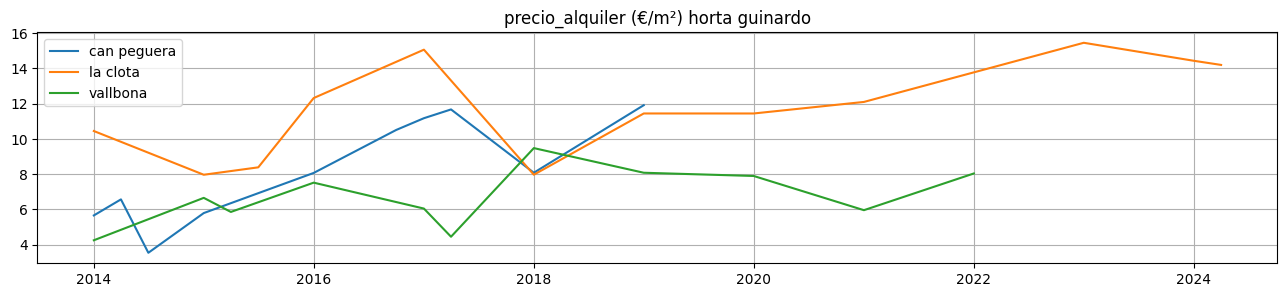

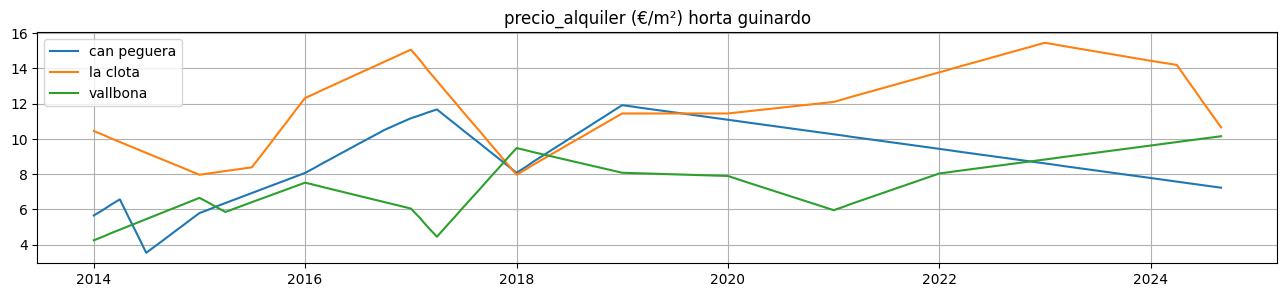

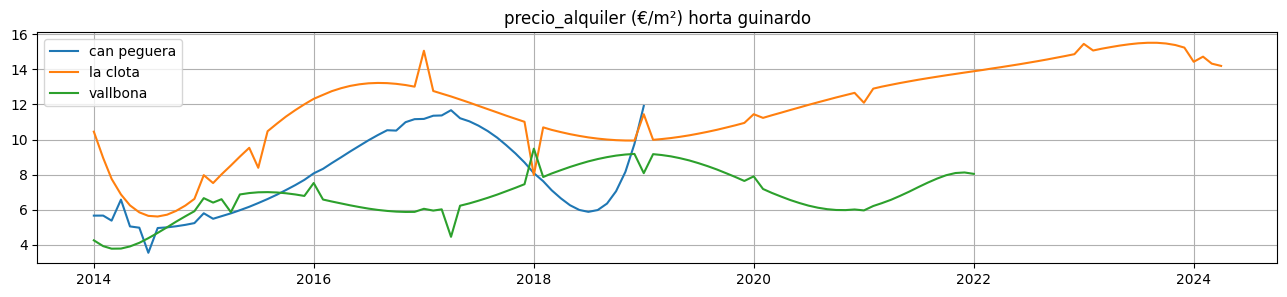

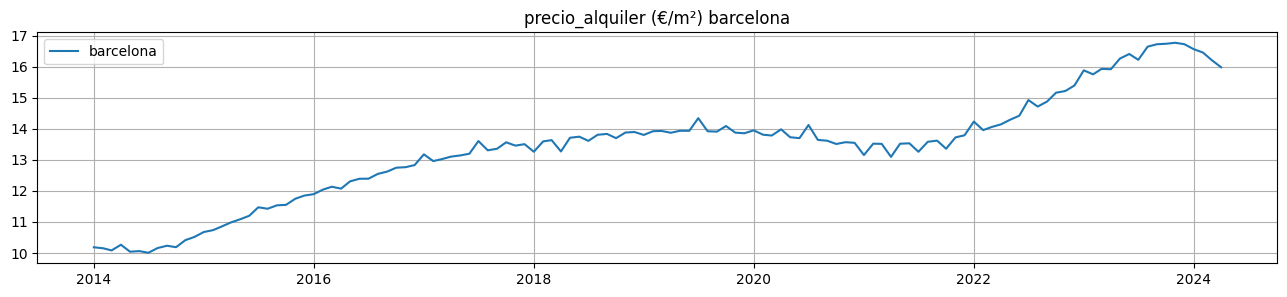

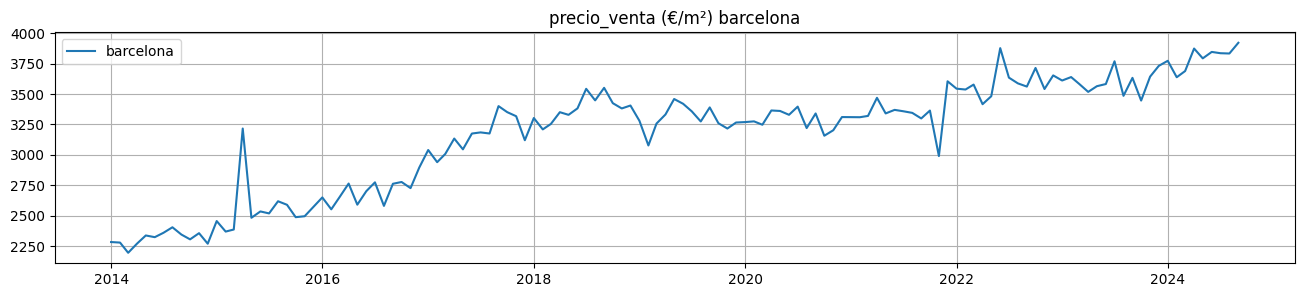

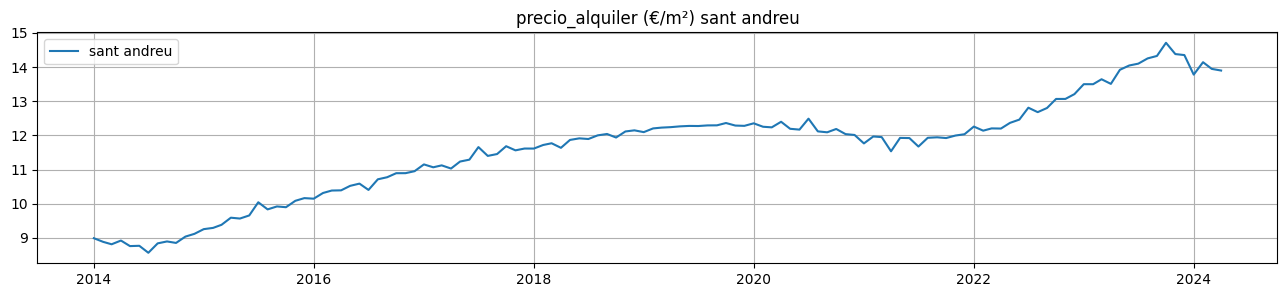

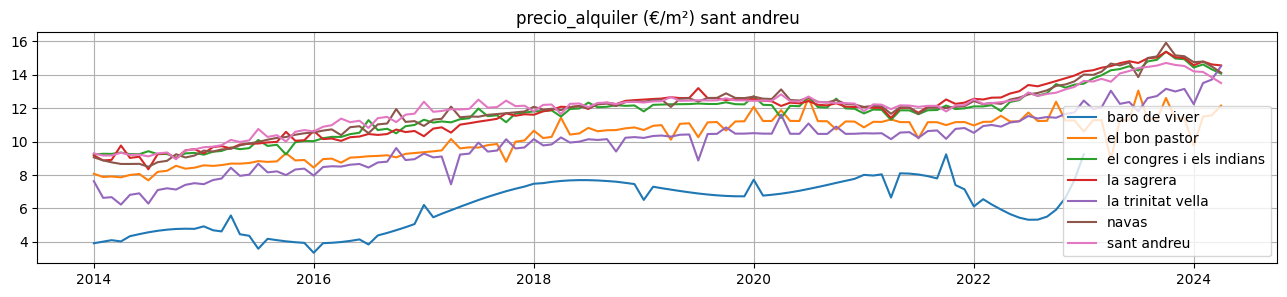

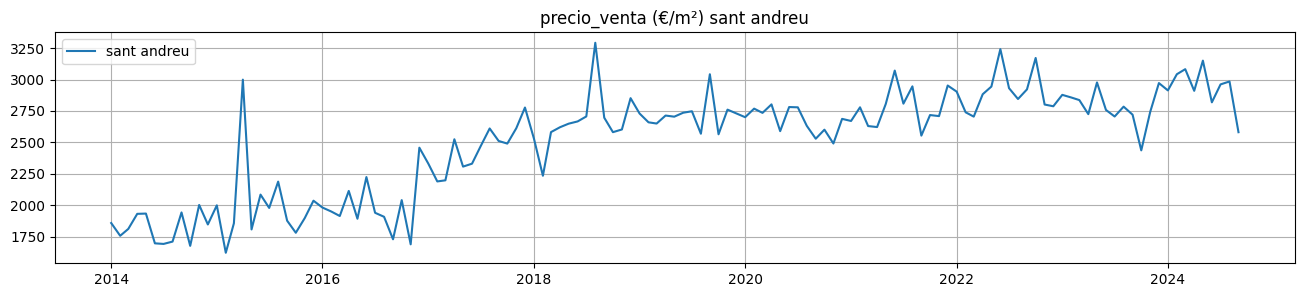

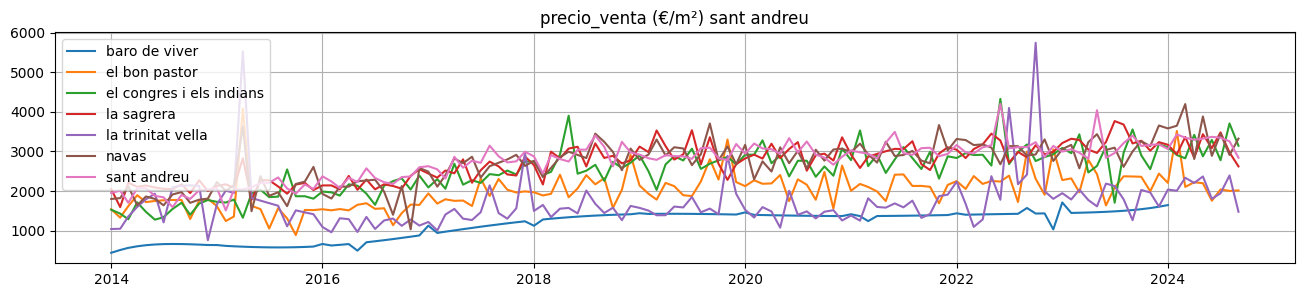

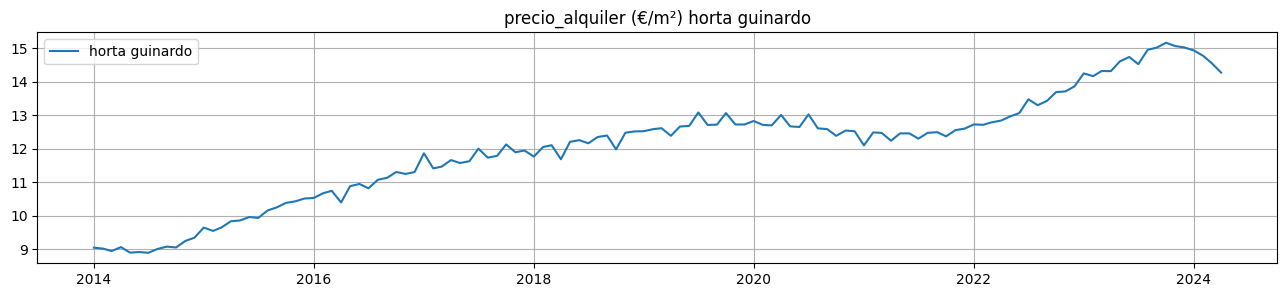

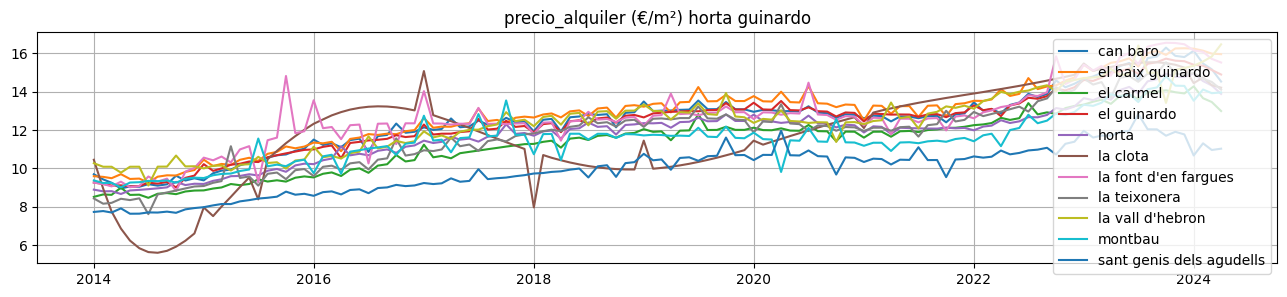

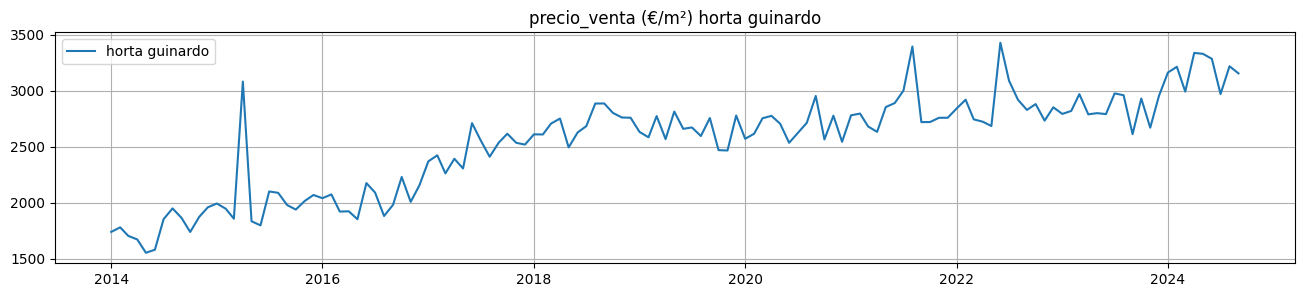

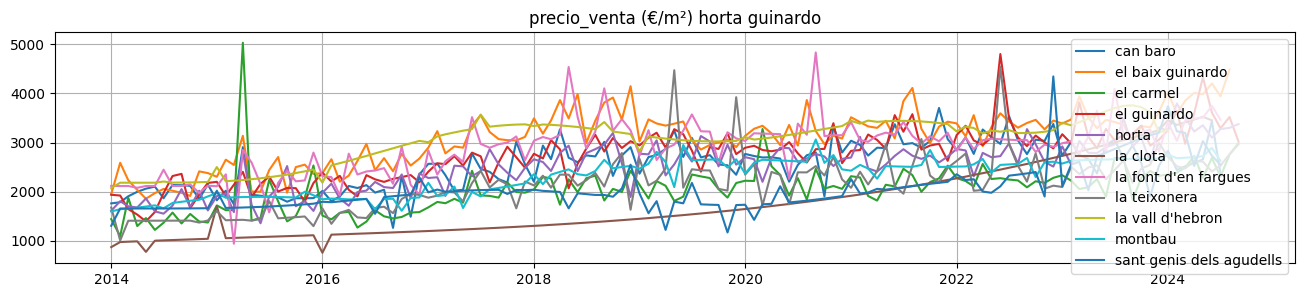

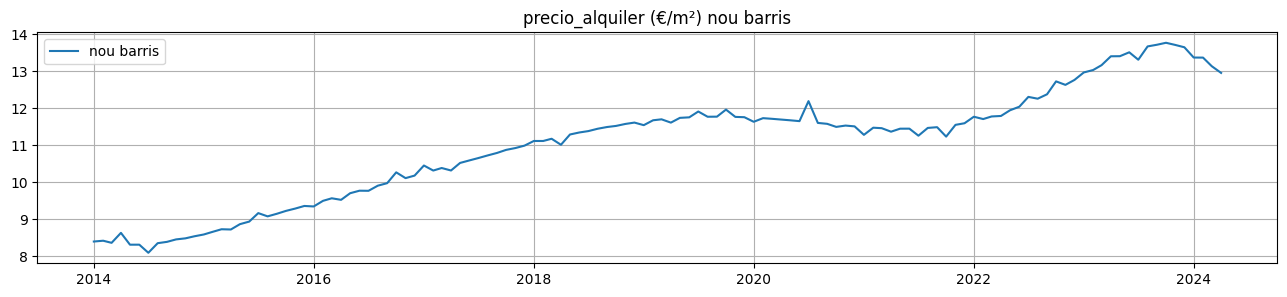

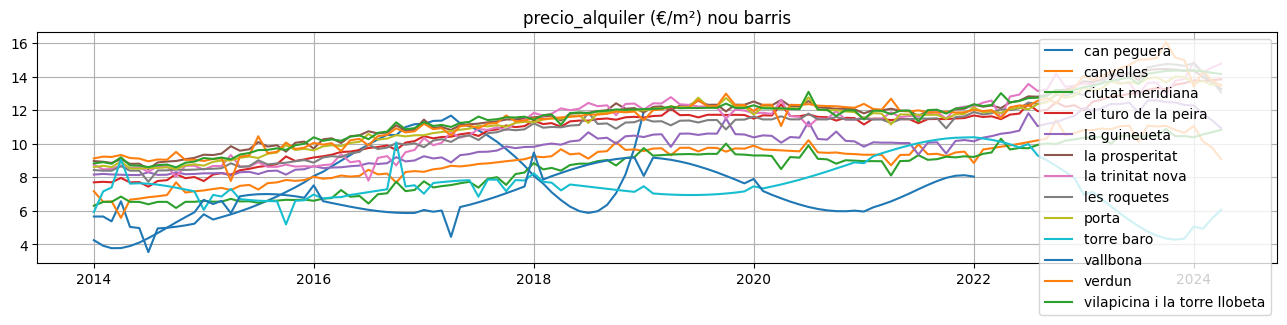

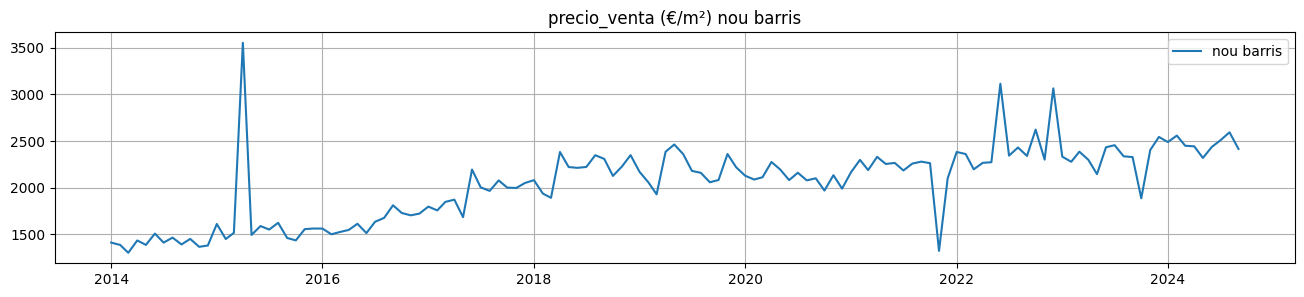

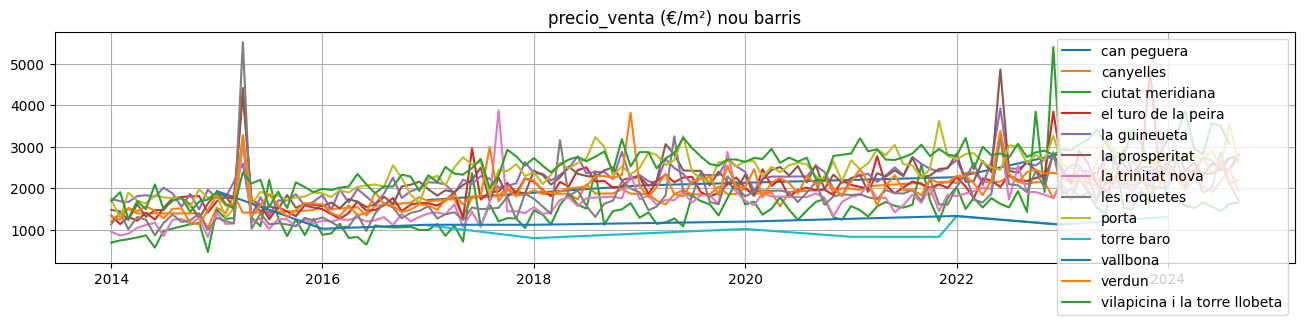

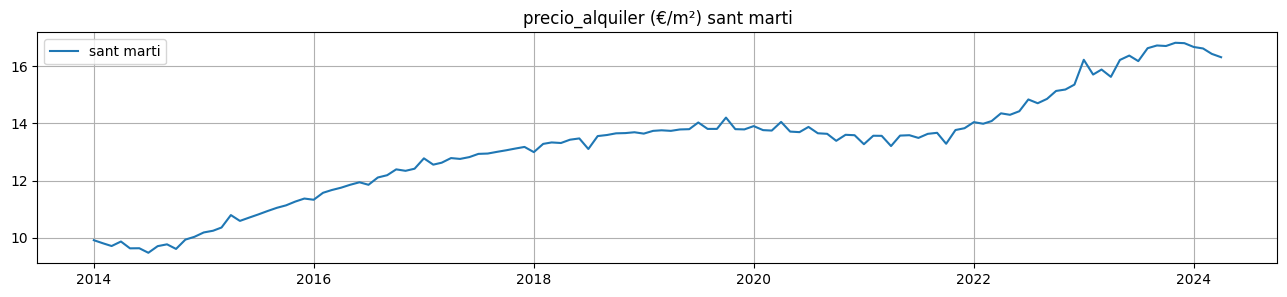

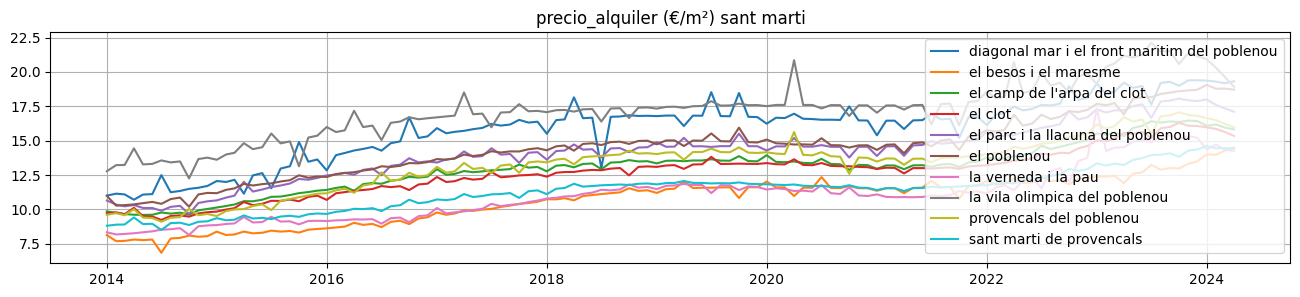

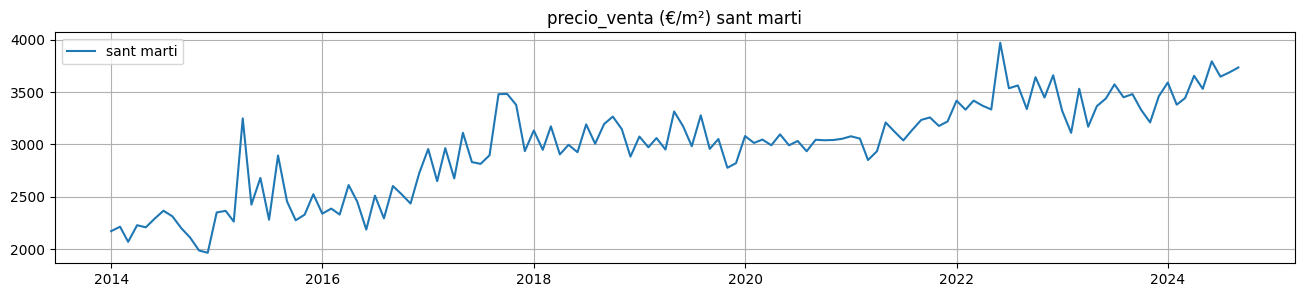

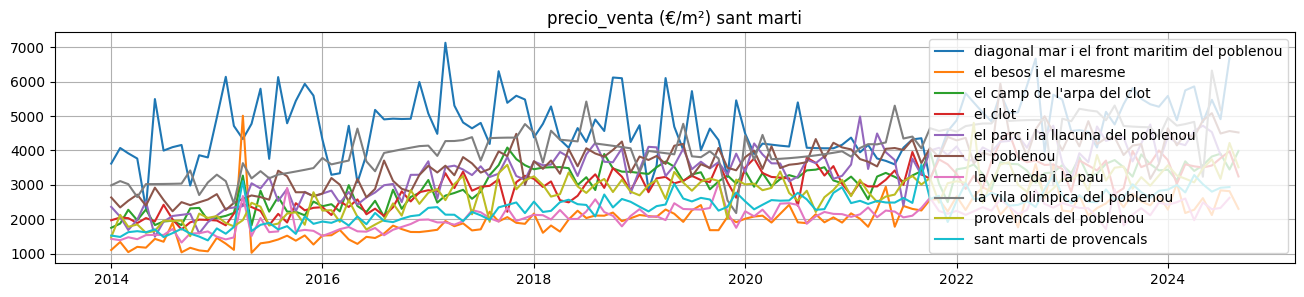

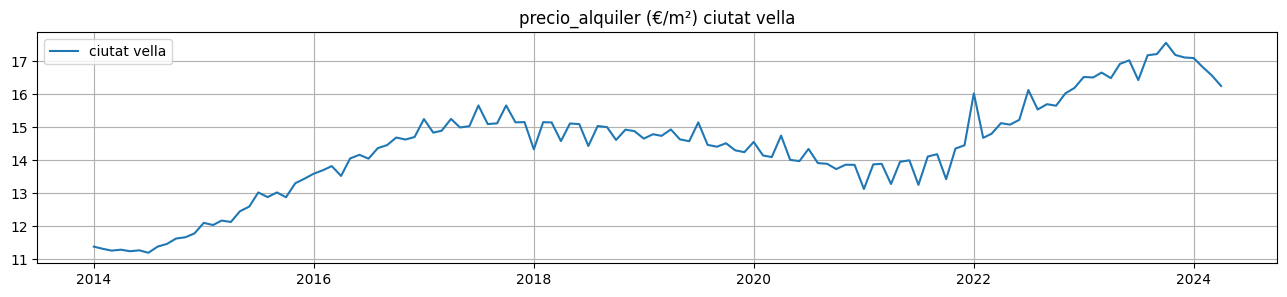

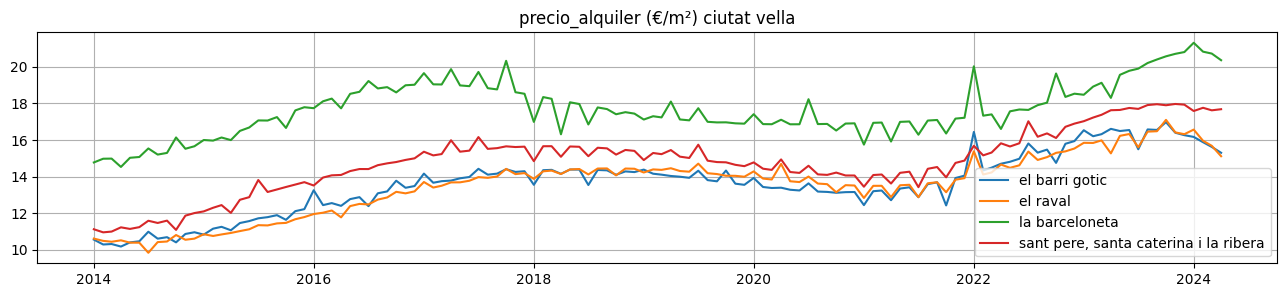

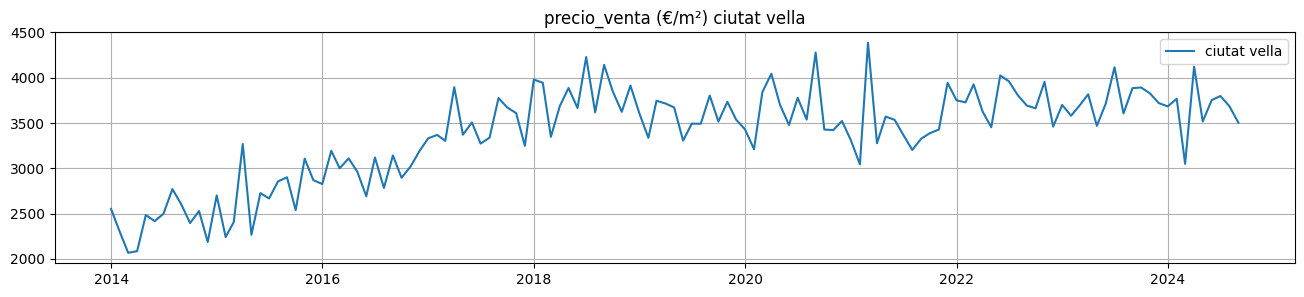

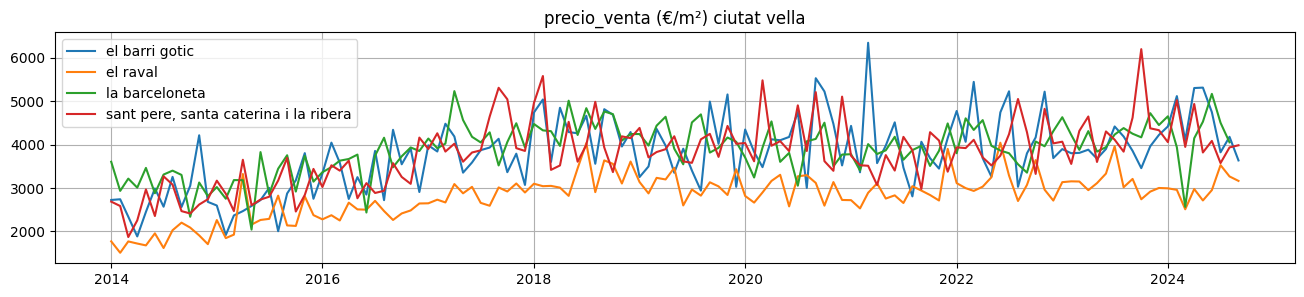

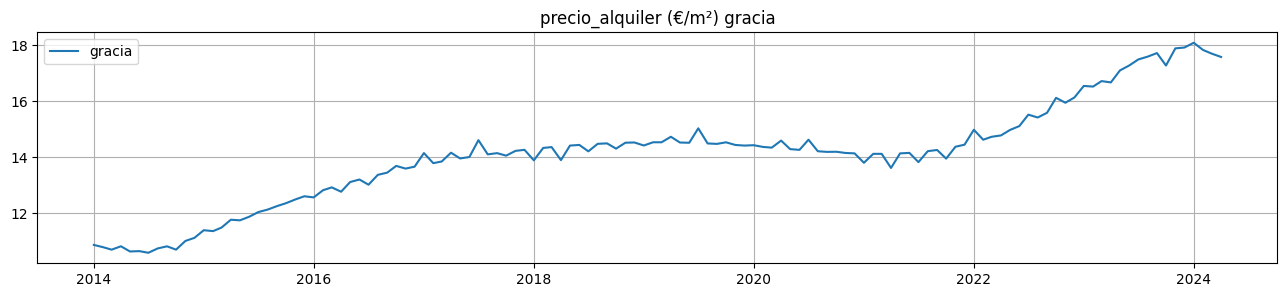

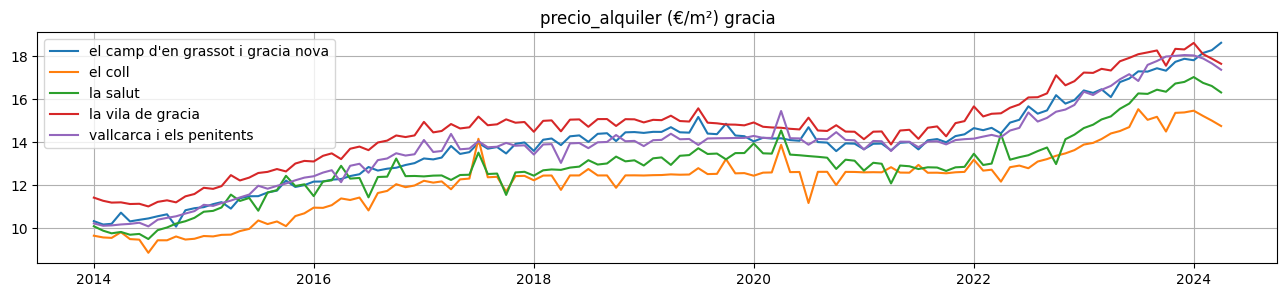

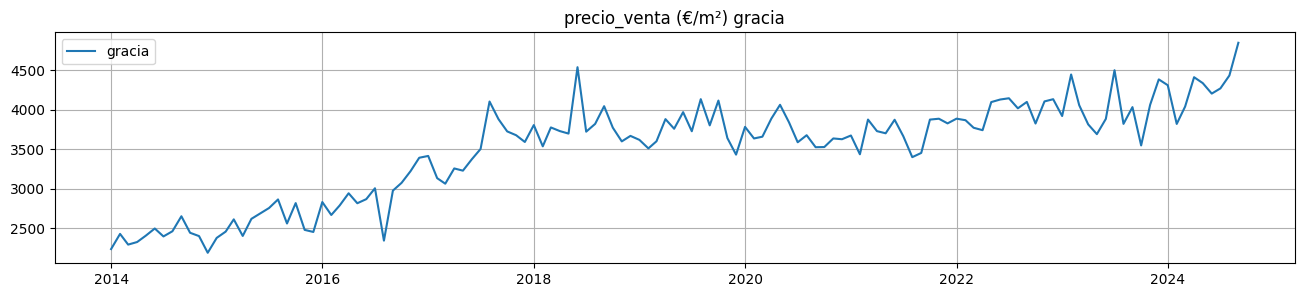

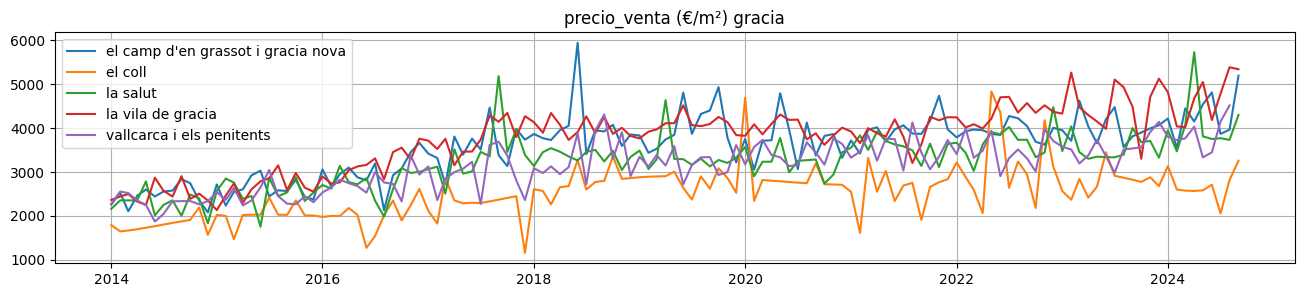

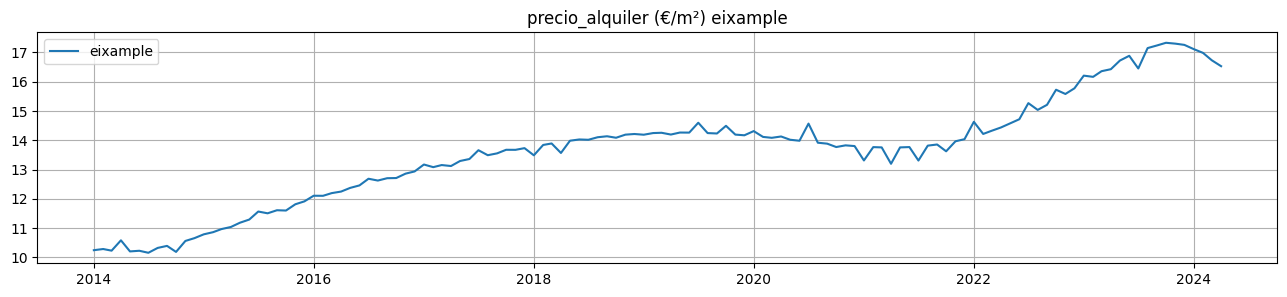

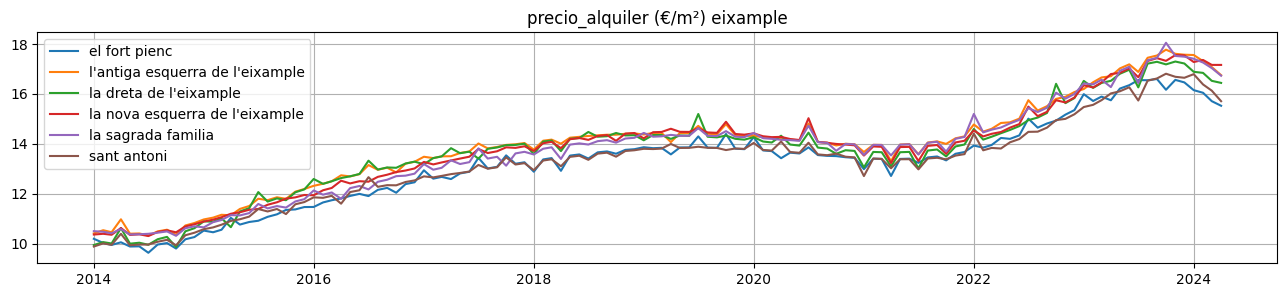

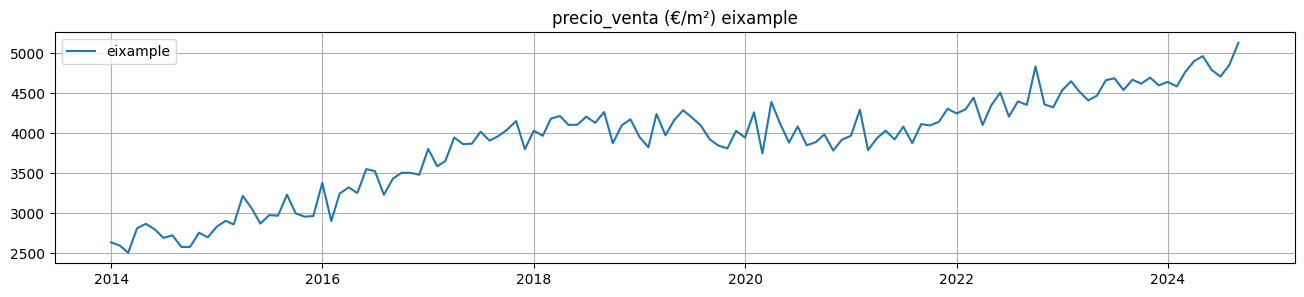

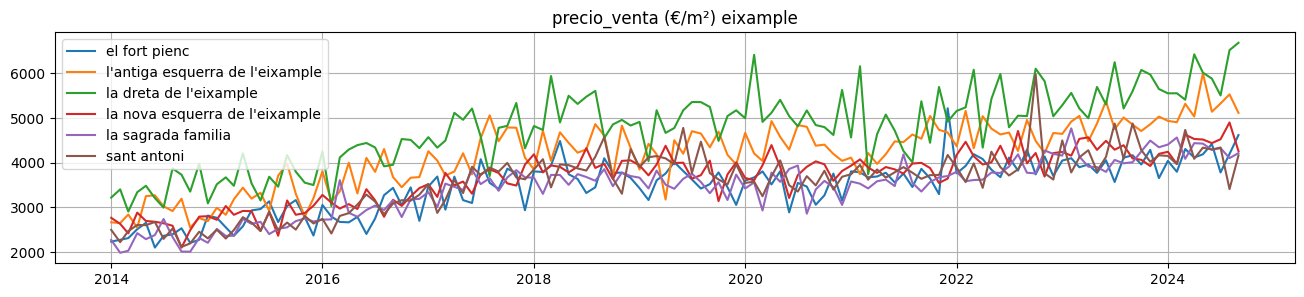

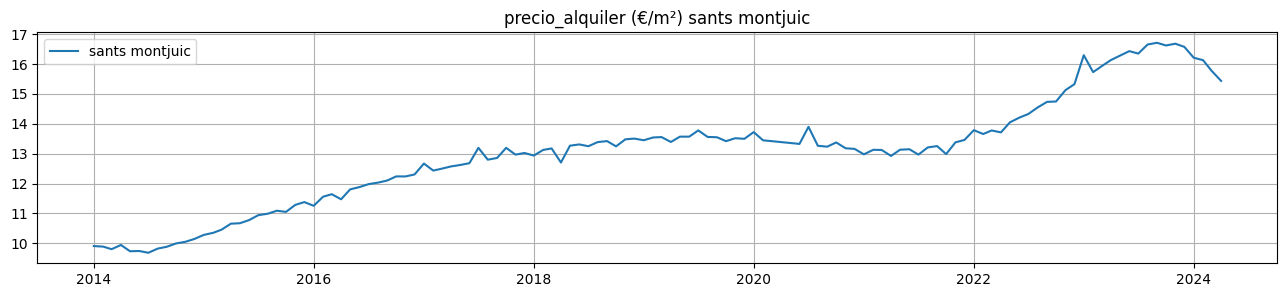

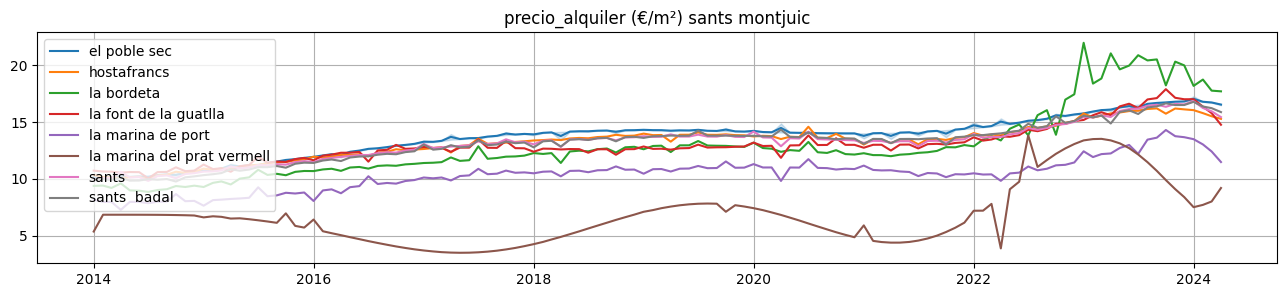

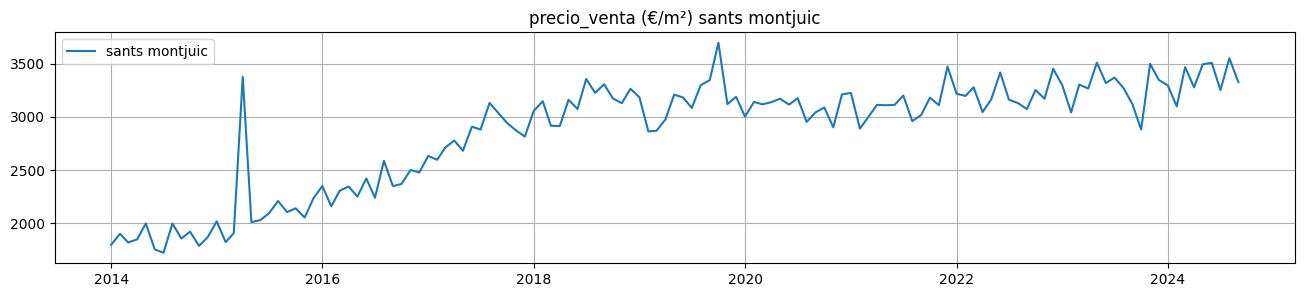

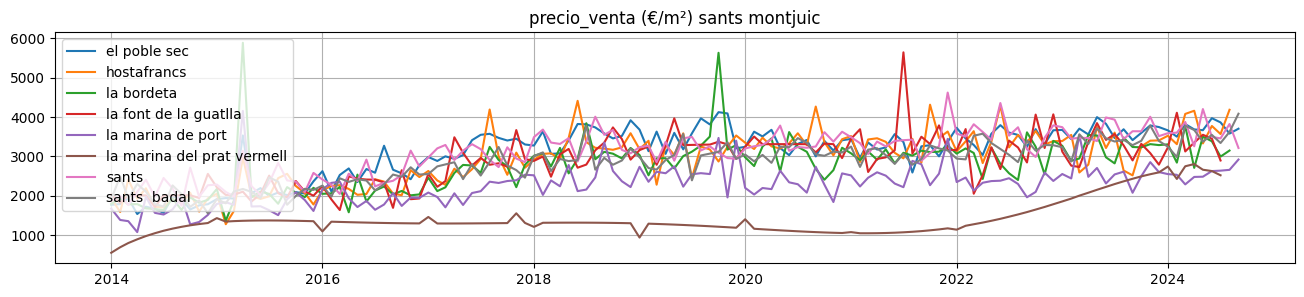

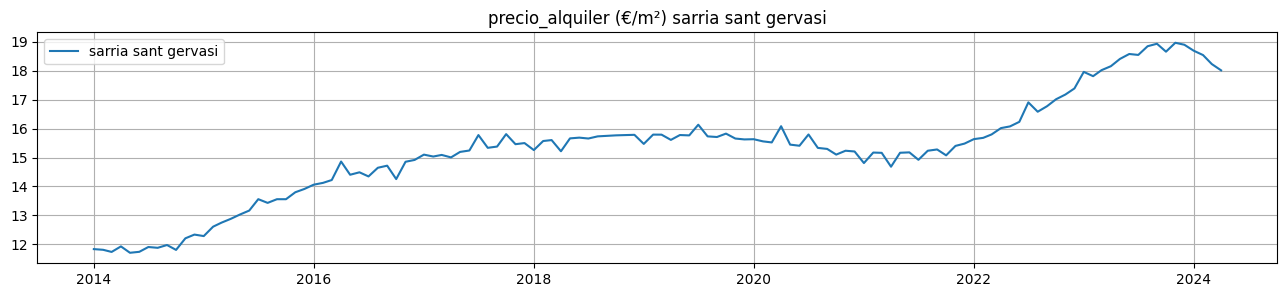

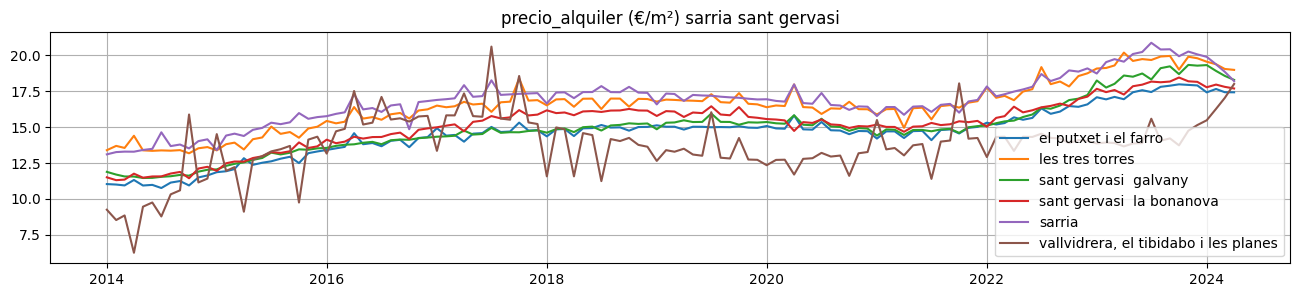

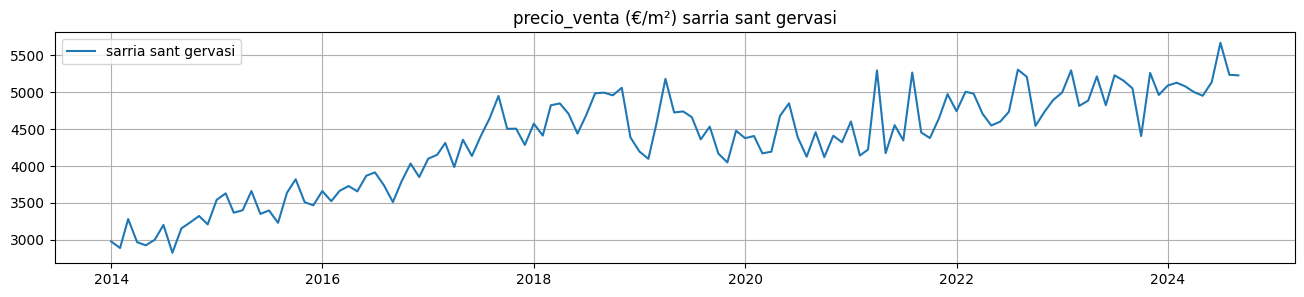

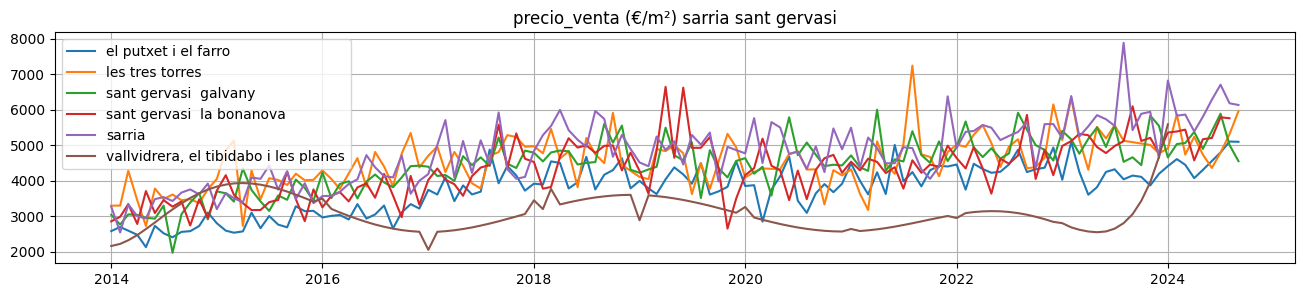

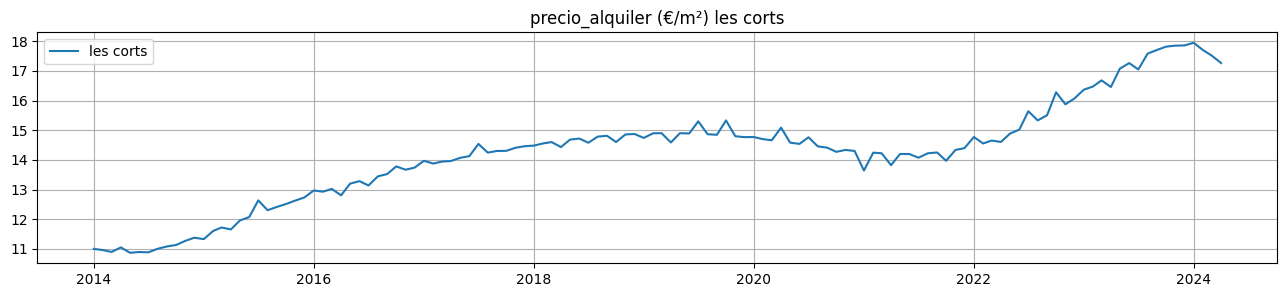

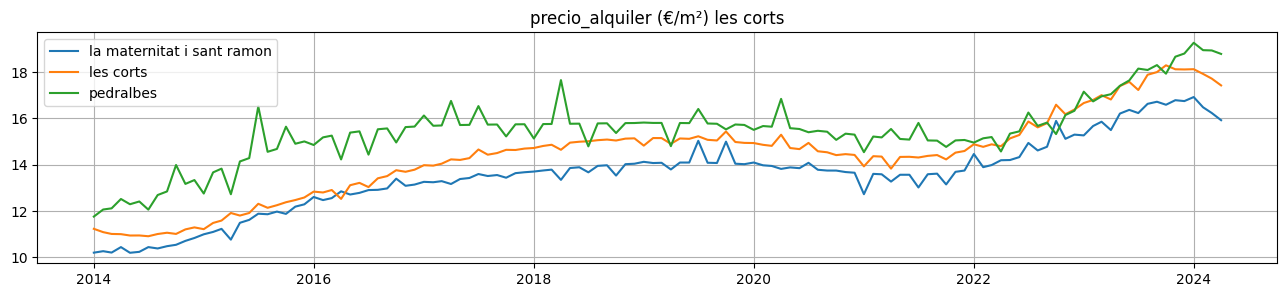

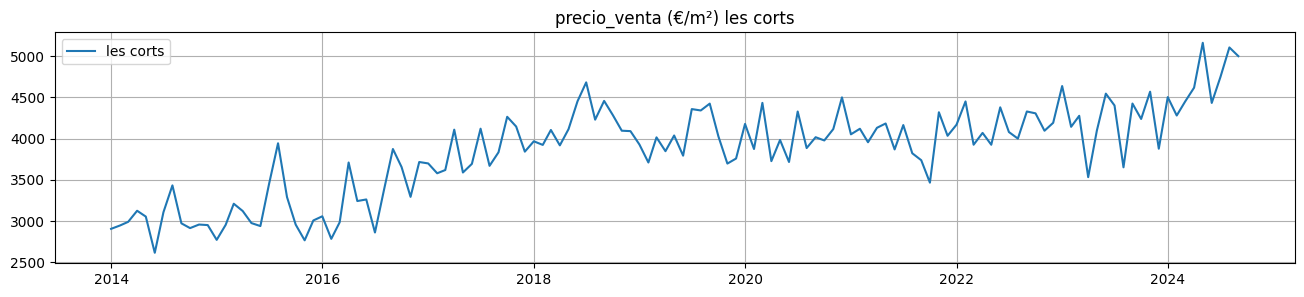

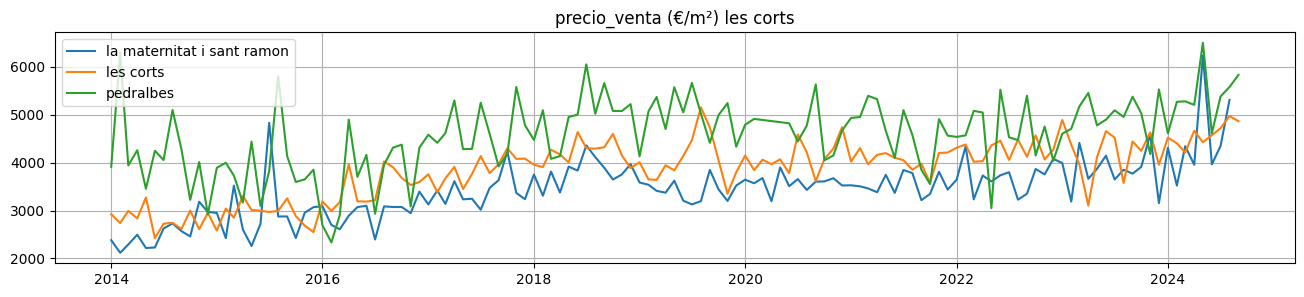

In [42]:
def plot_dist(df, field, figsize=(16, 4), title='', model=None):
    fig = plt.figure(figsize=figsize)
    for c in df['nombre'].unique():
        # sns.scatterplot(x='mes', y=field, data=df[df['nombre'] == c], markers='.')
        sns.lineplot(x='mes', y=field, data=df[df['nombre'] == c], label=c)
        plt.title(f'{field} (€/m²) '+title)
    plt.grid(True)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

plot_dist(bcn_precios[bcn_precios['nombre'].isin(['la clota', 'can peguera', 'vallbona'])], 'precio_alquiler',figsize=(16,3), title='horta guinardo')
plot_dist(bcn_precios_int2[bcn_precios_int2['nombre'].isin(['la clota', 'can peguera', 'vallbona'])], 'precio_alquiler',figsize=(16,3), title='horta guinardo')
plot_dist(bcn_precios_int[bcn_precios_int['nombre'].isin(['la clota', 'can peguera', 'vallbona'])], 'precio_alquiler',figsize=(16,3), title='horta guinardo')

plot_dist(bcn_precios_int[bcn_precios_int['nombre'] == 'barcelona'], 'precio_alquiler',figsize=(16,3), title='barcelona')
plot_dist(bcn_precios_int[bcn_precios_int['nombre'] == 'barcelona'], 'precio_venta',figsize=(16,3), title='barcelona')


for dist in bcn_precios_int['nom_districte'].dropna().unique().tolist():
    plot_dist(bcn_precios_int[(bcn_precios_int['nom_districte'] == dist) & (bcn_precios_int['tipo'] == 'districte')], 'precio_alquiler',figsize=(16,3), title=dist)
    plot_dist(bcn_precios_int[(bcn_precios_int['nom_districte'] == dist) & (bcn_precios_int['tipo'] == 'barri')], 'precio_alquiler',figsize=(16,3), title=dist)
    plot_dist(bcn_precios_int[(bcn_precios_int['nom_districte'] == dist) & (bcn_precios_int['tipo'] == 'districte')], 'precio_venta',figsize=(16,3), title=dist)
    plot_dist(bcn_precios_int[(bcn_precios_int['nom_districte'] == dist) & (bcn_precios_int['tipo'] == 'barri')], 'precio_venta',figsize=(16,3), title=dist)

In [43]:
bcn_precios.to_csv('datasets/gen_bcn_precios.csv', index=False)
bcn_precios_int.to_csv('datasets/gen_bcn_precios_int.csv', index=False)
barrios.to_csv('datasets/gen_bcn_barrios.csv', index=False)
bcn_precios

tipo         nombre                       mes  precio_alquiler  \
0         barri  baro de viver 2014-01-01 00:00:00+00:00             3.92   
1         barri  baro de viver 2014-02-01 00:00:00+00:00              NaN   
2         barri  baro de viver 2014-03-01 00:00:00+00:00              NaN   
3         barri  baro de viver 2014-04-01 00:00:00+00:00             4.03   
4         barri  baro de viver 2014-05-01 00:00:00+00:00              NaN   
...         ...            ...                       ...              ...   
10960  municipi      barcelona 2024-05-01 00:00:00+00:00              NaN   
10961  municipi      barcelona 2024-06-01 00:00:00+00:00              NaN   
10962  municipi      barcelona 2024-07-01 00:00:00+00:00              NaN   
10963  municipi      barcelona 2024-08-01 00:00:00+00:00              NaN   
10964  municipi      barcelona 2024-09-01 00:00:00+00:00              NaN   

       precio_venta  superficie_venta  codi_districte nom_districte  \
0        438.500000              92.0               9   sant andreu   
1               NaN               NaN               9   sant andreu   
2               NaN              56.0               9   sant andreu   
3               NaN               NaN               9   sant andreu   
4               NaN               NaN               9   sant andreu   
...             ...               ...             ...           ...   
10960   3792.943830               NaN              -1           NaN   
10961   3845.827810          122345.0              -1           NaN   
10962   3835.180837               NaN              -1           NaN   
10963   3832.821747               NaN              -1           NaN   
10964   3920.930902               NaN              -1           NaN   

       codi_barri  
0              58  
1              58  
2              58  
3              58  
4              58  
...           ...  
10960          -1  
10961          -1  
10962          -1  
10963          -1  
10964          -1  

[10965 rows x 9 columns]